In [466]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision
import cv2
import random
from IPython.display import clear_output

In [ ]:
# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class RGBADataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, f) for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGBA")
        if self.transform:
            image = self.transform(image)
        return image, 0  # 0を返すことで2つの値を返すようにする

In [483]:
# データセットの準備
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
dataset = RGBADataset("../../Skins/Skins", transform=transform)

In [484]:
num_samples = 10000
print(len(dataset))
subset_indices = random.sample(range(len(dataset)), num_samples)
num_skins = [dataset[i] for i in subset_indices]

dataloader = torch.utils.data.DataLoader(num_skins)

945061


In [501]:
# Encoder-Decoderモデルの定義
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, 3, stride=2, padding=1),  # 入力チャンネル数を4に変更
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 4, 4, stride=2, padding=1),  # 出力チャンネル数を4に変更
            nn.Sigmoid(),  # 出力値を0から1の範囲に制限
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# モデルをデバイスに配置
model = EncoderDecoder().to(device)

In [502]:
# 損失関数と最適化手法の設定
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [503]:
# 訓練ループ
num_epochs = 10
for epoch in range(num_epochs):
    for data in tqdm(dataloader):
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        loss.backward()
        optimizer.step()

    # clear_output(True)
    # print(f"\rEpoch {epoch+1}/{num_epochs}, Loss: {loss.item()}",end="")

100%|██████████| 10000/10000 [00:42<00:00, 236.70it/s]


In [519]:
# モデルの保存
torch.save(model.state_dict(), "Guided_Diffusion/guided_diffusion_model.pth")

In [520]:
# モデルのインスタンス化
model = EncoderDecoder()
model.load_state_dict(torch.load("Guided_Diffusion/guided_diffusion_model.pth"))
model.eval()

EncoderDecoder(
  (encoder): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)

In [521]:
# 生成するデータ数とノイズの次元を指定
num_samples = 1
noise_dim = 10

# ランダムなノイズベクトルを生成
z = torch.randn(num_samples, noise_dim)

# 入力データの生成（サイズは64x64）
z = torch.randn(1, 4, 64, 64)

# モデルに入力データを渡して画像を生成
with torch.no_grad():
    generated_image = model(z)

In [522]:
# dir_path = "Created_Skin/"
# files = os.listdir(dir_path)
# cv2.imwrite(f'{dir_path}ai_{len(files)+1}.png', generated_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())

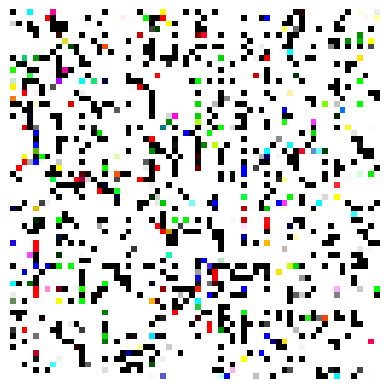

In [523]:
# 画像を表示
# print(generated_image)
plt.imshow(generated_image.squeeze(0).permute(1, 2, 0).detach().numpy(), interpolation='nearest')
plt.axis('off')
plt.show()